## Importing rrquired modules

In [21]:
import dlib, cv2, pickle,os
import matplotlib.pyplot as plt
import numpy as np
from imutils.face_utils import FaceAligner
import inspect

## Global variables

In [22]:
def initializer():
    detector = dlib.get_frontal_face_detector()
    face_encoder = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')
    pose_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(pose_predictor)
    modelFile = "opencv_face_detector_uint8.pb"
    configFile = "opencv_face_detector.pbtxt"
    net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)
    return detector, face_encoder, pose_predictor, fa, net
    

In [23]:
print(type(initializer()))

<class 'tuple'>


## Function for training model

In [24]:
def training(train_path):
    faces = list()
    name = list()
    detector, face_encoder, pose_predictor, fa, net = initializer()
    for im in os.listdir(trainpath):
        faceAligned = faceDetection(os.path.join(trainpath,im), detector, fa, net)
        faces = faceRecognitionTrainig(faceAligned,faces, face_encoder, pose_predictor)
        name.append(im)
    faces = np.array(faces)
    name = np.array(name)
    np.save('face_repr.npy', faces)
    np.save('labels.npy', name)
    return faces,name

## Function to detect Face

In [25]:
def faceDetection(im, detector, fa, net):
    
    img = cv2.imread(im)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    frameHeight = img.shape[0]
    frameWidth = img.shape[1]
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.7:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceAligned = fa.align(img, gray,dlib.rectangle(x1,y1,x2,y2))
            return faceAligned
            
            

## Function to recognize Face for Train Image 

In [26]:
def faceRecognitionTrainig(faceAligned,faces, face_encoder, pose_predictor):
    landmark = pose_predictor(faceAligned,dlib.rectangle(0,0,faceAligned.shape[0],faceAligned.shape[1]))
    face_descriptor = face_encoder.compute_face_descriptor(faceAligned, landmark, num_jitters=2)
    faces.append(face_descriptor)      
    return faces

## Function to recognize Face for Test Image

In [27]:
def faceRecognitionTesting(faceAligned, face_encoder, pose_predictor, faces,name):
    landmark = pose_predictor(faceAligned,dlib.rectangle(0,0,faceAligned.shape[0],faceAligned.shape[1]))
    face_descriptor = face_encoder.compute_face_descriptor(faceAligned, landmark, num_jitters=2)
    score = np.linalg.norm(faces - np.array(face_descriptor), axis=1)
    imatches = np.argsort(score)
    score = score[imatches]
    return (name[imatches][:10].tolist())

## Function for Testing the model

In [28]:
def testing(im, faces, name):
    detector, face_encoder, pose_predictor, fa, net = initializer()
    faceAligned = faceDetection(im , detector, fa, net)
    images = faceRecognitionTesting(faceAligned, face_encoder, pose_predictor,faces,name)
    return images
        
    

In [29]:
trainpath = "passport/faces"
faces,name = training(trainpath)
im = "passport/face2/2709_114.jpg"
images = testing(im, faces, name)

## To test the result

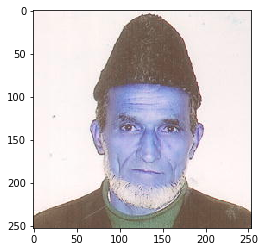

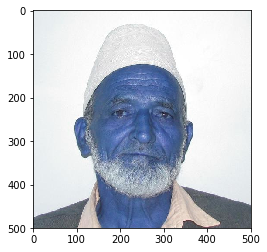

In [30]:
plt.figure()
plt.imshow(cv2.imread(im))
plt.figure()
plt.imshow(cv2.imread(os.path.join(trainpath,images[0])))